In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import subprocess
import time

In [2]:
class MoelIsinga:
	def __init__(self, rozmiar_siatki, enerigia_początkowa) -> None:
		self.L = rozmiar_siatki
		self.E = enerigia_początkowa
		self.siatka = np.ones(shape=(self.L,self.L))

	def Delta_E(self, i, j):
		gorny = i-1
		dolny = i+1
		if (i == 0):   gorny = self.L-1
		if (i == self.L-1): dolny = 0
		
		prawy = j+1
		lewy  = j-1
		if (j == 0):   lewy  = self.L-1
		if (j == self.L-1): prawy = 0

		E_pocz = self.siatka[i][j] * (self.siatka[i][lewy] + self.siatka[i][prawy] + self.siatka[gorny][j] + self.siatka[dolny][j])
		E_konc = -E_pocz
		return E_pocz - E_konc

	def doprowadzenie_do_stanu_rownowagi(self, liczba_krokow):
		self.magnetyzacja = self.L * self.L
		self.E_Start  = -2 * self.L * self.L
		self.E_Duszka = self.E - self.E_Start

		for _ in range(liczba_krokow):
			i = np.random.randint(self.L)
			j = np.random.randint(self.L)
			dE = self.Delta_E(i, j)
			if (dE <= self.E_Duszka):			
				self.E_Duszka -= dE
				self.E_Start  += dE
				self.siatka[i][j] = -self.siatka[i][j]
				self.magnetyzacja += 2*self.siatka[i][j]

	def zliczanie_srednich(self, liczba_krokow):
		E_Duszka_Do_Sredniej = 0
		magnetyzacja_tot = 0
		E_tot = 0
		
		for _ in range(liczba_krokow):
			# Petla statystycznie po kazdym spinie
			for _ in range(self.L*self.L):
				i = np.random.randint(self.L)
				j = np.random.randint(self.L)
				dE = self.Delta_E(i,j)
				if (dE <= self.E_Duszka):
					self.siatka[i][j ]= -self.siatka[i][j]
					self.E_Duszka -= dE
					self.E_Start  += dE
					self.magnetyzacja += 2*self.siatka[i][j]

			E_Duszka_Do_Sredniej += self.E_Duszka
			E_tot += self.E_Start
			magnetyzacja_tot += abs(self.magnetyzacja)

		self.Srednia_Energia_Ukladu = E_tot / liczba_krokow
		self.Srednia_E_Duszka = (E_Duszka_Do_Sredniej) / liczba_krokow
		self.Srednia_Magnetyzacja = magnetyzacja_tot / liczba_krokow / (self.L*self.L)
		self.Temperatura = 4.0 / (np.log(1 + 4.0/self.Srednia_E_Duszka))

class MoelIsingaMacro:
	def __init__(self, rozmiar_siatki, Temperatura) -> None:
		self.L = rozmiar_siatki
		self.Temperatura = Temperatura
		self.siatka = np.ones(shape=(self.L,self.L))

	def Delta_E(self, i, j):
		gorny = i-1
		dolny = i+1
		if (i == 0):   gorny = self.L-1
		if (i == self.L-1): dolny = 0
		
		prawy = j+1
		lewy  = j-1
		if (j == 0):   lewy  = self.L-1
		if (j == self.L-1): prawy = 0

		E_pocz = self.siatka[i][j] * (self.siatka[i][lewy] + self.siatka[i][prawy] + self.siatka[gorny][j] + self.siatka[dolny][j])
		E_konc = -E_pocz
		return E_pocz - E_konc

	def doprowadzenie_do_stanu_rownowagi(self, liczba_krokow):
		self.magnetyzacja = self.L * self.L
		self.E_Start  = -2 * self.L * self.L

		for _ in range(liczba_krokow):
			i = np.random.randint(self.L)
			j = np.random.randint(self.L)
			dE = self.Delta_E(i, j)
			if (dE <= 0):				
				self.E_Start  += dE
				self.siatka[i][j] = -self.siatka[i][j]
				self.magnetyzacja += 2*self.siatka[i][j]
			else:
				if np.random.rand() < np.exp(-dE/self.Temperatura):
					self.E_Start  += dE
					self.siatka[i][j] = -self.siatka[i][j]
					self.magnetyzacja += 2*self.siatka[i][j]


	def zliczanie_srednich(self, liczba_krokow):
		magnetyzacja_tot = 0
		E_tot = 0
		
		for _ in range(liczba_krokow):
			# Petla statystycznie po kazdym spinie
			for _ in range(self.L*self.L):
				i = np.random.randint(self.L)
				j = np.random.randint(self.L)
				dE = self.Delta_E(i,j)
				if (dE <= 0):				
					self.E_Start  += dE
					self.siatka[i][j] = -self.siatka[i][j]
					self.magnetyzacja += 2*self.siatka[i][j]
				else:
					if np.random.rand() < np.exp(-dE/self.Temperatura):
						self.E_Start  += dE
						self.siatka[i][j] = -self.siatka[i][j]
						self.magnetyzacja += 2*self.siatka[i][j]

			E_tot += self.E_Start
			magnetyzacja_tot += abs(self.magnetyzacja)

		self.Srednia_Energia_Ukladu = E_tot / liczba_krokow
		self.Srednia_Magnetyzacja = magnetyzacja_tot / liczba_krokow / (self.L*self.L)

@dataclass
class ExperimentParameters:
    E_min: int
    E_max: int
    E_step: int
    L: int

@dataclass
class ExperimentParametersMacro:
    T_min: int
    T_max: int
    T_step: int
    L: int

# Zadanie 1

In [87]:
ExperimentParametersList = []
ExperimentParametersList.append(ExperimentParameters(-184, -24, 8, 10))
ExperimentParametersList.append(ExperimentParameters(-768, -32, 32, 20))
ExperimentParametersList.append(ExperimentParameters(-3072, -128, 128, 40))

Execution time: 16.83290386199951 seconds


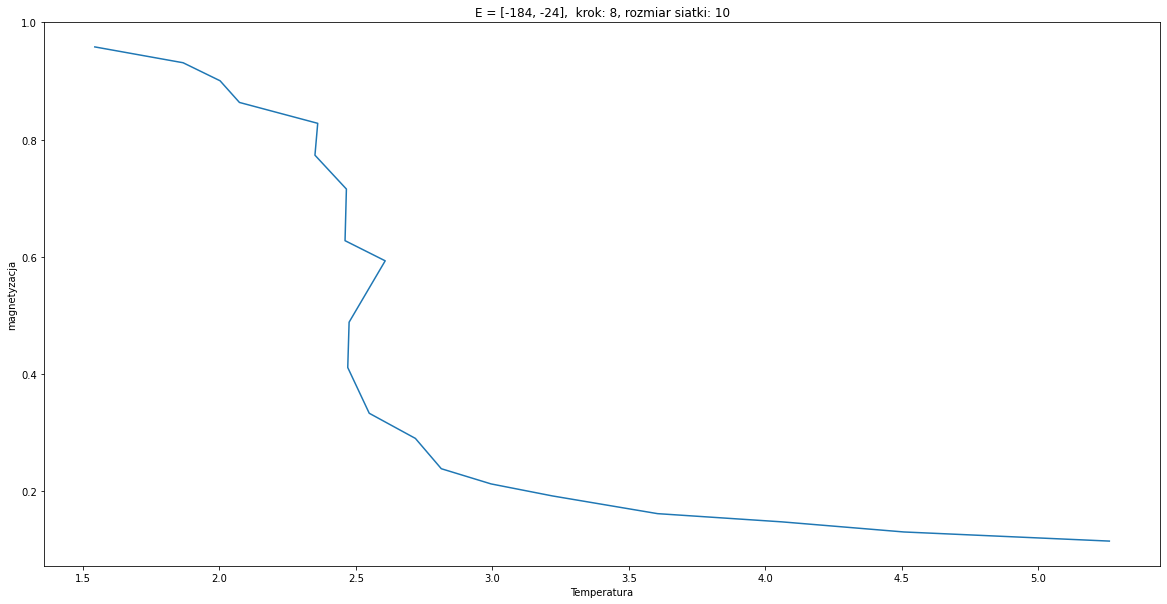

Execution time: 75.46822381019592 seconds


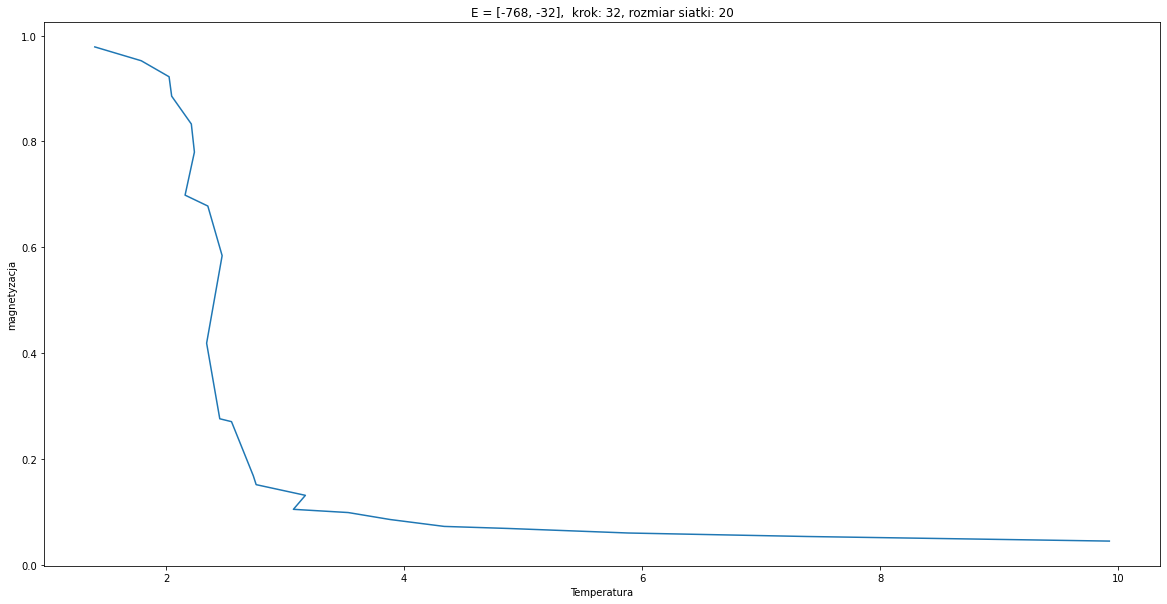

Execution time: 303.94327330589294 seconds


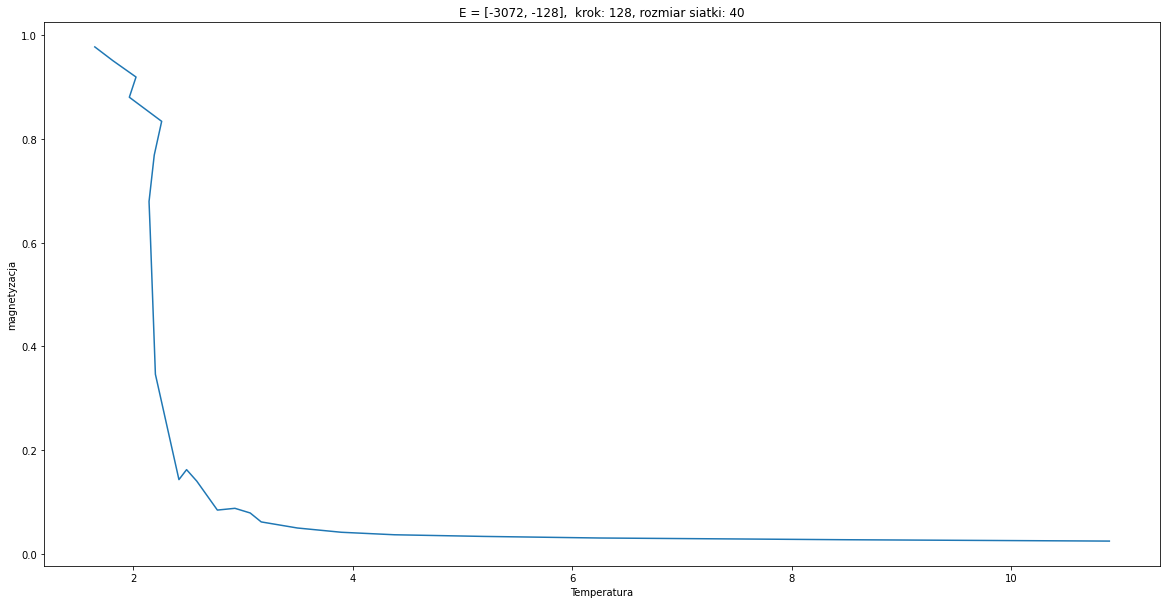

In [77]:
for ep in ExperimentParametersList:
    E = np.arange(ep.E_min, ep.E_max, ep.E_step)
    liczba_krokow = 1000

    magnetyzacja = []
    T = []
    st = time.time()
    for e in E:
        ising = MoelIsinga(ep.L,e)
        ising.doprowadzenie_do_stanu_rownowagi(liczba_krokow)
        ising.zliczanie_srednich(liczba_krokow)
        magnetyzacja.append(ising.Srednia_Magnetyzacja)
        T.append(ising.Temperatura)
    et = time.time()
    print('Execution time:', et - st, 'seconds')
    plt.figure(figsize=(20,10))
    plt.plot(T, magnetyzacja)
    plt.xlabel('Temperatura')
    plt.ylabel('magnetyzacja')
    plt.title(f"E = [{ep.E_min}, {ep.E_max}],  krok: {ep.E_step}, rozmiar siatki: {ep.L}")
    plt.show()

# Zadanie 2

In [103]:
ExperimentParametersMacroList = []
ExperimentParametersMacroList.append(ExperimentParametersMacro(1, 6, 1, 10))
ExperimentParametersMacroList.append(ExperimentParametersMacro(1, 6, 1, 20))
ExperimentParametersMacroList.append(ExperimentParametersMacro(1, 6, 0.1, 40))

Execution time: 5.450713157653809 seconds


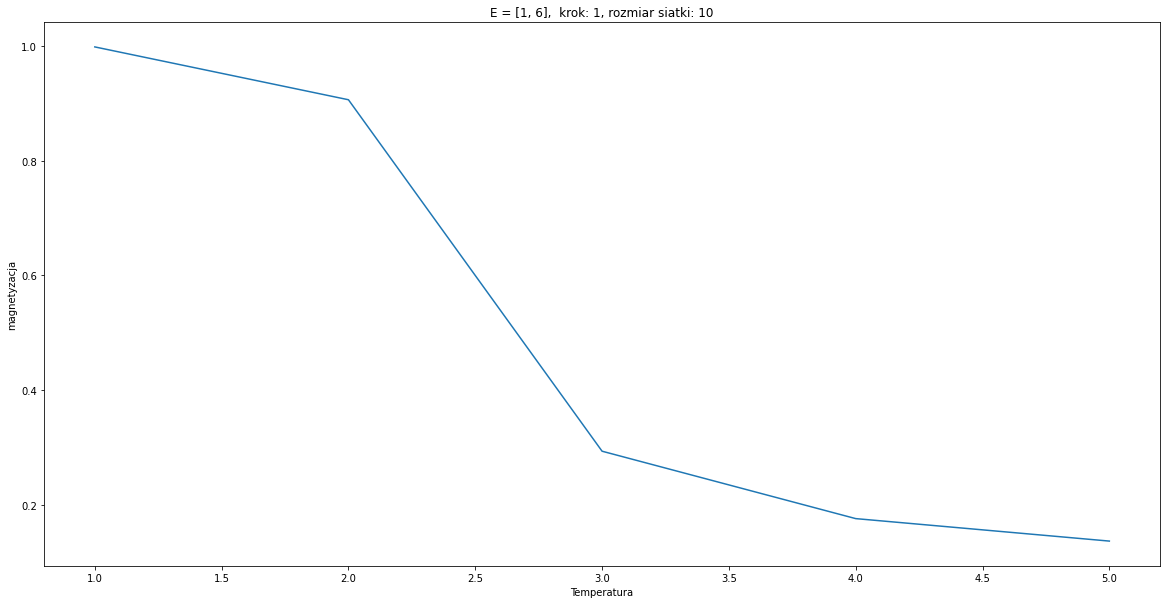

Execution time: 22.08620572090149 seconds


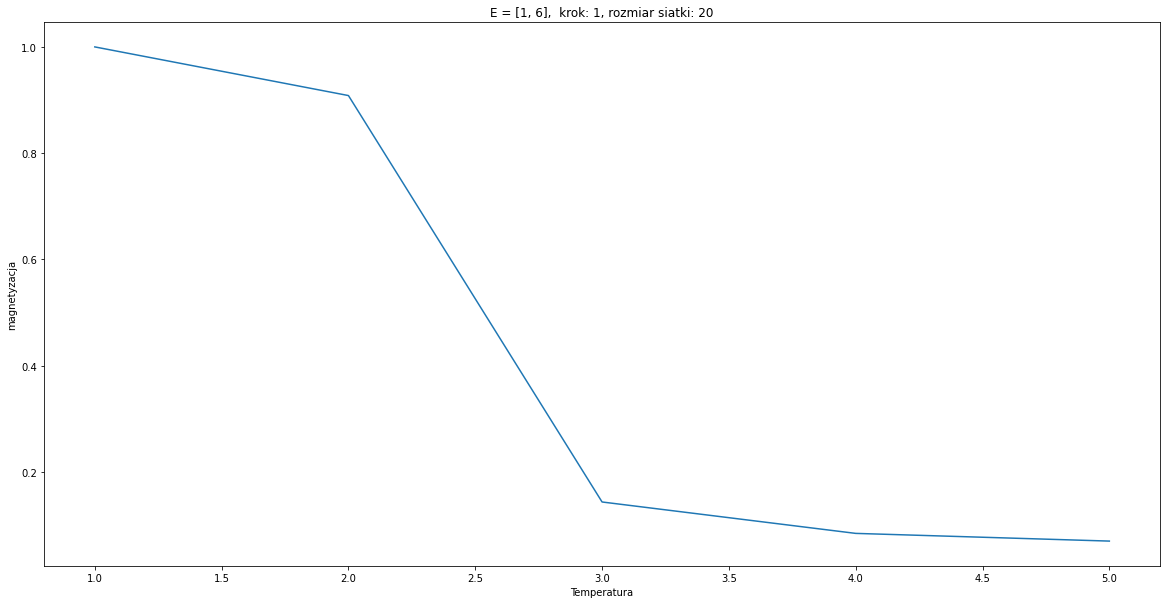

Execution time: 863.780398607254 seconds


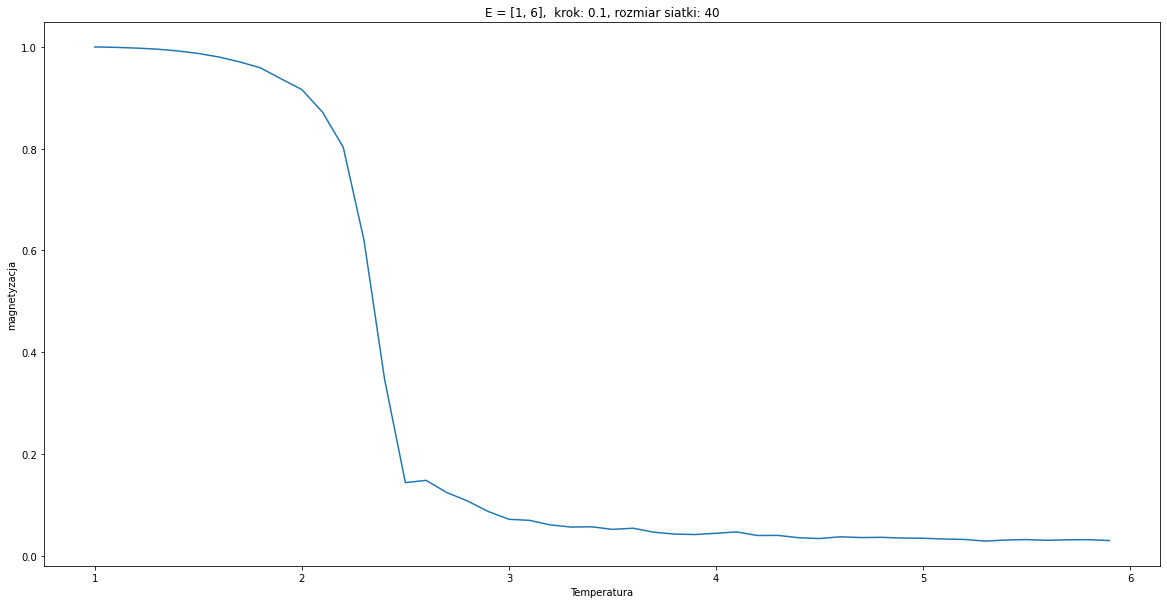

In [104]:
for ep in ExperimentParametersMacroList:
    Temps = np.arange(ep.T_min,ep.T_max, ep.T_step)
    liczba_krokow = 1000

    magnetyzacja = []
    T = []

    st = time.time()
    for t in Temps:
        ising = MoelIsingaMacro(ep.L, t)
        ising.doprowadzenie_do_stanu_rownowagi(liczba_krokow)
        ising.zliczanie_srednich(liczba_krokow)
        magnetyzacja.append(ising.Srednia_Magnetyzacja)
        T.append(ising.Temperatura)
    et = time.time()
    print('Execution time:', et - st, 'seconds')
    plt.figure(figsize=(20,10))
    plt.plot(T, magnetyzacja)
    plt.xlabel('Temperatura')
    plt.ylabel('magnetyzacja')
    plt.title(f"E = [{ep.T_min}, {ep.T_max}],  krok: {ep.T_step}, rozmiar siatki: {ep.L}")
    plt.show()

Przez przypadek w ostatniej symulacji liczyłem z małym krokiem 0.1 stopnia zamiast 1 stopień, górne "kolanko" wyszło bardzo ładnie, a dolne nie szczególnie. Ciekawe - nie mam pojęcia czemu. W C++ też wyszło podobnie tzn, góre ładnie, dolne troochę gorzej.

In [8]:
863/14

61.642857142857146

^ tyle razy wolniejszy jest python w problemnie z zadanie 2 niż C++

# Podsumowanie - implementacja w python
Niestety Python wolny, ale da się przeżyć. Czas wykonania jednego zadania to około 6 min, w C++ w zadanie pierwsze 8 sekund, a drugie 30 sekund.

# Wywoływanie C++ z Python'a
Postanowiłem wywoływac c++ z Python aby wygodnie się działało z danymi i eksperymenty wykonywały się szybko.

In [43]:
p = subprocess.Popen(['wsl', './a.out', '10', '-184', '1000'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, error = p.communicate()
print(output.decode("utf-8"))
out = output.decode("utf-8").split("\n")
T = out[4]
magnetyzacja = out[5]

./a.out
10
-184
1000
1.40051
0.95808



# Zadanie 1

In [6]:
ExperimentParametersList = []
ExperimentParametersList.append(ExperimentParameters(-184, -24, 8, 10))
ExperimentParametersList.append(ExperimentParameters(-768, -32, 32, 20))
ExperimentParametersList.append(ExperimentParameters(-3072, -128, 128, 40))

Execution time: 1.9699628353118896 seconds


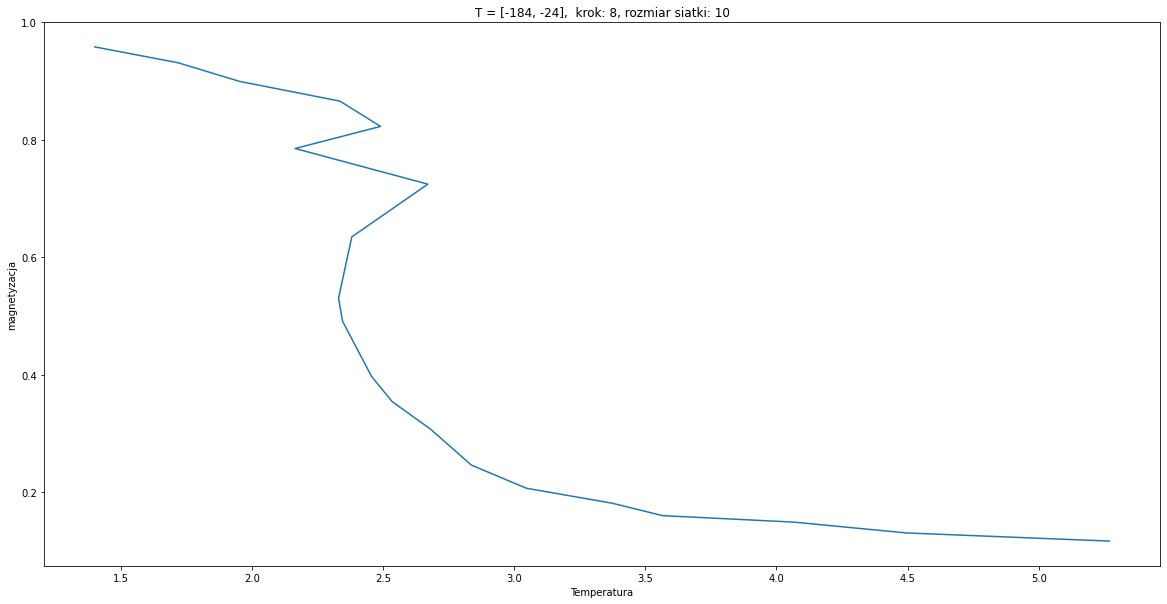

Execution time: 2.226142168045044 seconds


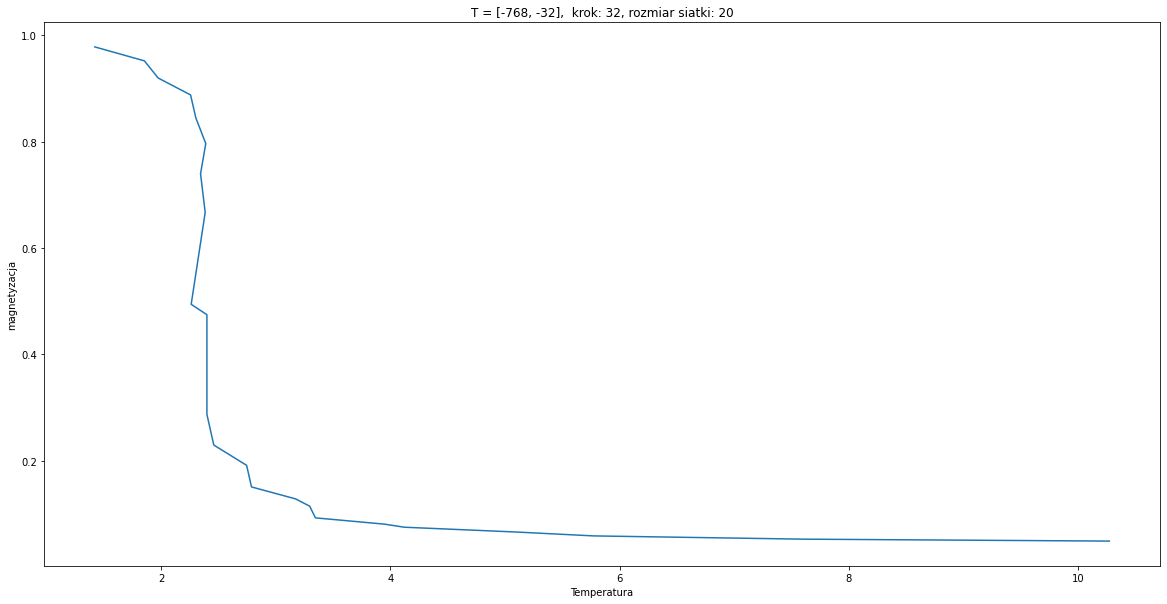

Execution time: 2.928257703781128 seconds


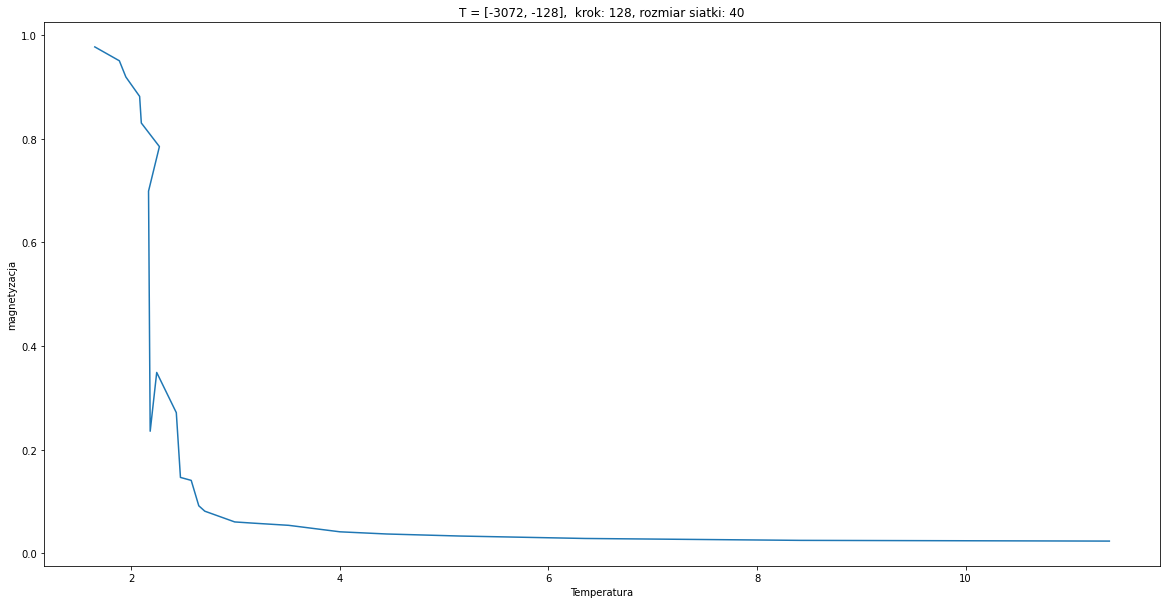

In [7]:
for ep in ExperimentParametersList:
    E = np.arange(ep.E_min,ep.E_max,ep.E_step)
    liczba_krokow = 1000

    magnetyzacja = []
    T = []

    st = time.time()
    for e in E:
        p = subprocess.Popen(['wsl', './a.out', str(ep.L), str(e), str(liczba_krokow)], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output, error = p.communicate()
        # print(output.decode("utf-8"))
        out = output.decode("utf-8").split("\n")
        magnetyzacja.append(float(out[5]))
        T.append(float(out[4]))
    et = time.time()
    print('Execution time:', et - st, 'seconds')
    plt.figure(figsize=(20,10))
    plt.plot(T, magnetyzacja)
    plt.xlabel('Temperatura')
    plt.ylabel('magnetyzacja')
    plt.title(f"T = [{ep.E_min}, {ep.E_max}],  krok: {ep.E_step}, rozmiar siatki: {ep.L}")
    plt.show()

# Zadanie 2

In [4]:
ExperimentParametersMacroList = []
ExperimentParametersMacroList.append(ExperimentParametersMacro(1.5, 10, 0.1, 10))
ExperimentParametersMacroList.append(ExperimentParametersMacro(1.5, 10, 0.1, 20))
ExperimentParametersMacroList.append(ExperimentParametersMacro(1.5, 10, 0.1, 40))

Execution time: 9.86829137802124 seconds


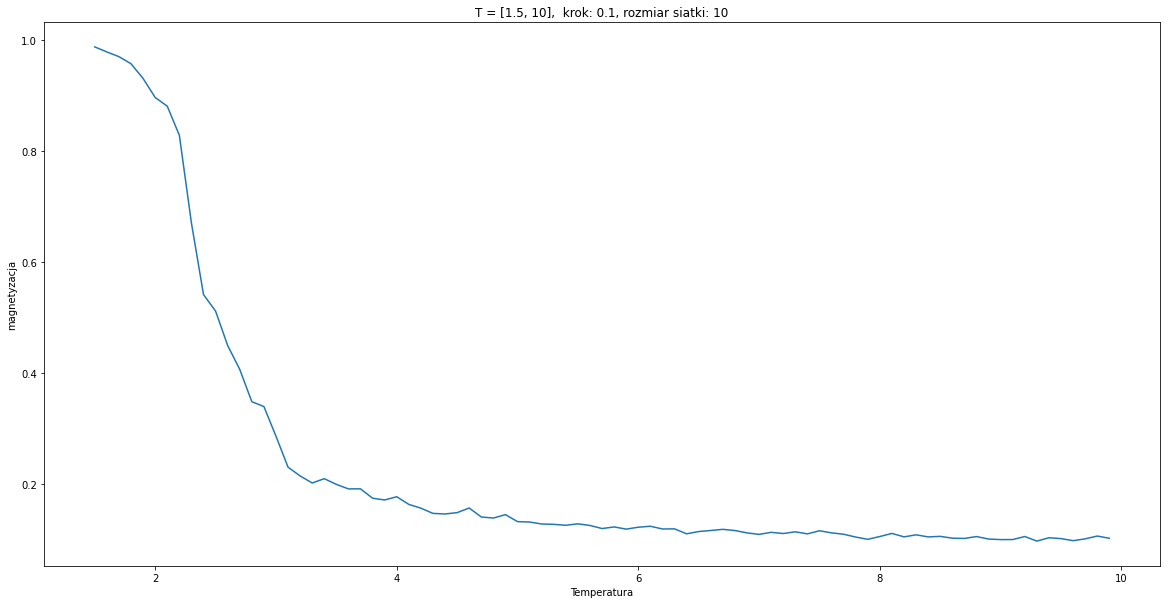

Execution time: 9.533070087432861 seconds


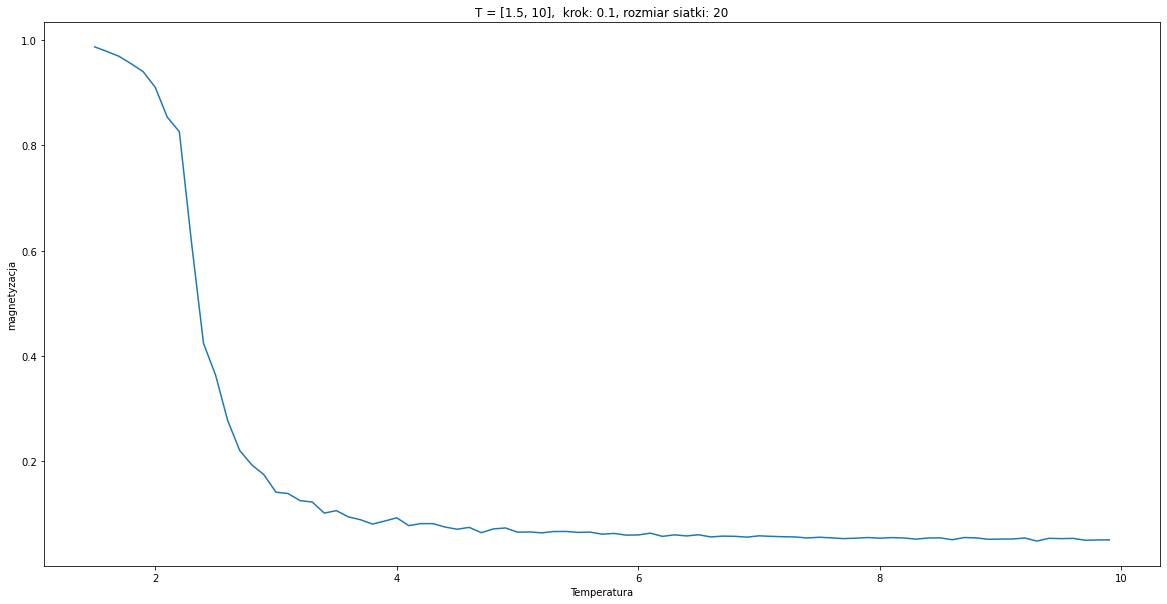

Execution time: 14.176197290420532 seconds


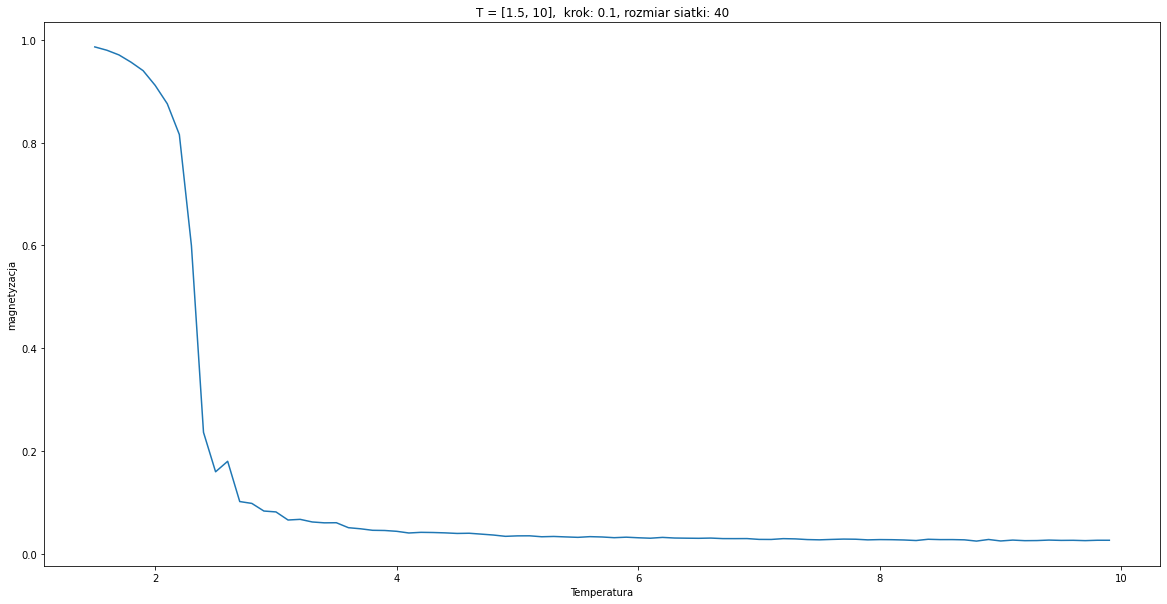

In [5]:
for ep in ExperimentParametersMacroList:
    Temps = np.arange(ep.T_min,ep.T_max, ep.T_step)
    liczba_krokow = 1000

    magnetyzacja = []
    T = []

    st = time.time()
    for t in Temps:
        p = subprocess.Popen(['wsl', './a_macro.out', str(ep.L), str(t), str(liczba_krokow)], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output, error = p.communicate()
        # print(output.decode("utf-8"))
        out = output.decode("utf-8").split("\n")
        magnetyzacja.append(float(out[5]))
        T.append(float(out[4]))
    et = time.time()
    print('Execution time:', et - st, 'seconds')
    plt.figure(figsize=(20,10))
    plt.plot(T, magnetyzacja)
    plt.xlabel('Temperatura')
    plt.ylabel('magnetyzacja')
    plt.title(f"T = [{ep.T_min}, {ep.T_max}],  krok: {ep.T_step}, rozmiar siatki: {ep.L}")
    plt.show()

# Podsumowanie i wnioski

Udało się zaimplementować oba ćwiczenia w obu językach. Python niestety jest około 10 razy wolniejszy niż C++. Jeżeli chodzi o wyniki to Implementacja w Pythonie i C++ zwraca podobne wyniki i zgodne z założeniami, więc uważam obie za poprawne. Jeżeli chodzi o różnicę miedzy zadaniem pierwszym a drugim. Wyniki w zadaniu drugim otrzymane metodą makrokanoniczną są mniejsza zaszumione. Wykorzystanie duszka wprowadza więcej losowości i wariancja wyniku magnetyzacji jest większa. Ponadto w zdaniu drugim w implementacji w C++ wykorzystałem mniejszy krok, co też pozwala lepiej dokładnie zmierzyć punk przejścia. Do tego w zadaniu 2, funkcja jest znacznie bardziej gładka, co wynika z zastosowanej metody, a nie większej liczby punktów pomiarowych.